In [5]:
# Capturing images from video
import cv2
import glob
import os
from pathlib import Path
from shutil import copyfile
from data_aug.data_aug import *
from data_aug.bbox_util import *

videos = {
#   "wb1": "./videos/Beach Volleyball Women-s Gold Medal Match - Highlights London 2012 Olympics.mp4",
#   "wb2": "./videos/These Ladies fight for EVERY POINT 5 Gstaad -SUI- - 2019 FIVB Beach Volleyball World Tour.mp4",
#   "wb3": "./videos/Women-s Beach Volleyball - Best Highlights.mp4",
#   "wb4": "./videos/Women-s Beach Volleyball Crazy Actions - DIGS SAVES.mp4",
#   "wb5": "./videos/Women-s Most DRAMATIC Rallies of all Time Highlights from the Beach Volleyball World.mp4"  
#   "wb6": "./videos/EPIC Moments of Women-s Tournament FIVB Beach Volleyball Championships Hamburg 2019.mp4"
}

for k in videos:
  Path("./images-pre/{}".format(k)).mkdir(parents=True, exist_ok=True)
  
  print(videos[k])
  vidcap = cv2.VideoCapture(videos[k])
  fps = int(vidcap.get(cv2.CAP_PROP_FPS))
  
  count = 0
  success = True  

  while success:
      success, image = vidcap.read()
      if count%(5*fps) == 0 :
           cv2.imwrite('./images-pre/{}/frame{}.jpg'.format(k, count), image)
      count+=1

In [61]:
def convert_box(box):
  box = box[1:] + box[0:1]
  cx = box[0]
  cy = box[1]
  w = box[2]
  h = box[3]
  box[0] = (cx - w/2) * img_obj.shape[1]
  box[1] = (cy - h/2) * img_obj.shape[0]
  box[2] = box[0] + w * img_obj.shape[1]
  box[3] = box[1] + h * img_obj.shape[0]
  return box

def plot(img, boxes):
  for i in range(len(boxes)):
    boxes[i] = convert_box(boxes[i])
  boxes = np.array(boxes)
  plotted_img = draw_rect(img, boxes)
  plt.imshow(plotted_img)
  plt.show()

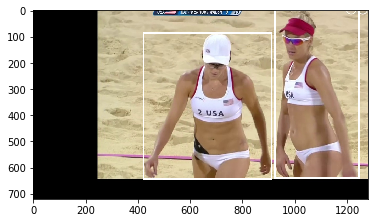

In [97]:
img = cv2.imread('./dataset/images/wb1-frame1375-tr2.jpg')[:,:,::-1]
with open('./dataset/labels/wb1-frame1375-tr2.txt', 'r') as f:
  boxes = [[float(s) for s in line.rstrip('\n').split()] for line in f]
plot(img, boxes)

In [94]:
%%time
import collections
import numpy as np
import random
train = []
val = []
Path('./dataset/images/').mkdir(parents=True, exist_ok=True)
Path('./dataset/labels/').mkdir(parents=True, exist_ok=True)

def transforms(image, label):
  img_obj = cv2.imread(image)[:,:,::-1]
  
  with open(label, 'r') as f:
    boxes = [[float(s) for s in line.rstrip('\n').split()] for line in f]
    for i in range(len(boxes)):
      boxes[i] = convert_box(boxes[i])
    boxes = np.array(boxes)
    
  img1, boxes1 = RandomHorizontalFlip(1)(img_obj.copy(), boxes.copy())
  img2, boxes2 = RandomScale(0.2, diff = True)(img_obj.copy(), boxes.copy())
  img3, boxes3 = RandomTranslate(0.2, diff = True)(img_obj.copy(), boxes.copy())
  img4, boxes4 = RandomHSV(100, 100, 100)(img_obj.copy(), boxes.copy())
  
  result = [[img1, boxes1.tolist()], [img2, boxes2.tolist()], [img3, boxes3.tolist()],\
            [img4, boxes4.tolist()]]
  
  for r in result:
    boxes = r[1]
    for i in range(len(boxes)):
      x1 = boxes[i][0]
      y1 = boxes[i][1]
      x2 = boxes[i][2]
      y2 = boxes[i][3]
      l = boxes[i][4]

      boxes[i][0] = int(l)
      boxes[i][1] = (x1+x2)/2/img_obj.shape[1]
      boxes[i][2] = (y1+y2)/2/img_obj.shape[0]
      boxes[i][3] = (x2-x1)/img_obj.shape[1]
      boxes[i][4] = (y2-y1)/img_obj.shape[0]
    
  return result    

for image in glob.iglob('./images-pre/**/*.jpg', recursive=True):
  p = Path(image)
  label =  (p.parent / p.stem).with_suffix('.txt')
  
  image_name = os.path.basename(image)
  label_name = os.path.basename(label)
  prefix = os.path.basename(p.parents[0])
  
  image_path = './dataset/images/{}-{}'.format(prefix, image_name)
  
  copyfile(str(image), image_path)
  copyfile(str(label), './dataset/labels/{}-{}'.format(prefix, label_name))
  
  if random.random() < .1:
    val.append(image_path)
  else:
    train.append(image_path)
    trs = transforms(image, label)
    for i in range(len(trs)):
      image_path = './dataset/images/{}-{}-tr{}.jpg'.format(prefix, p.stem, i)
      cv2.imwrite(image_path, cv2.cvtColor(trs[i][0], cv2.COLOR_RGB2BGR))
      with open('./dataset/labels/{}-{}-tr{}.txt'.format(prefix, p.stem, i), 'w+') as f:
        lines = [' '.join([str(round(y, 6)) for y in x]) for x in trs[i][1]]
        f.write('\n'.join(lines) + '\n')
      train.append(image_path)

CPU times: user 41.4 s, sys: 5.53 s, total: 46.9 s
Wall time: 45.8 s


In [95]:
with open('./dataset/train.txt', 'w+') as f:
  f.writelines(s + '\n' for s in train)
  
with open('./dataset/val.txt', 'w+') as f:
  f.writelines(s + '\n' for s in val)
len(train), len(val)

(1720, 50)

In [ ]:
# Yolov3 & Google Colab guide
# https://medium.com/@quangnhatnguyenle/how-to-train-yolov3-on-google-colab-to-detect-custom-objects-e-g-gun-detection-d3a1ee43eda1
# and
# https://github.com/AlexeyAB/darknet

In [ ]:
# todo augmentation tool https://github.com/Paperspace/DataAugmentationForObjectDetection